# Create model

### Create ImageDataBunch

In [11]:
import pandas as pd

pd.set_option('display.max_columns', 100)
train_info = pd.read_csv('data/train_dcm_png_info.csv')
merged = pd.read_csv('data/merged_details.csv')

In [16]:
files = os.listdir('data/test_png')

In [17]:
len(files)

3000

In [10]:
train_info[train_info.PatientID=='a102ee89-3806-4b01-ab43-fb39cc14944d']

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,PatientName,PatientID,PatientBirthDate,PatientSex,PatientAge,BodyPartExamined,ViewPosition,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,InstanceNumber,PatientOrientation,SamplesperPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,PixelData
395,ISO_IR 100,Secondary Capture Image Storage,1.2.276.0.7230010.3.1.4.8323329.9531.151787434...,19010101,0.0,NaN,CR,WSD,NaN,view: AP,a102ee89-3806-4b01-ab43-fb39cc14944d,a102ee89-3806-4b01-ab43-fb39cc14944d,NaN,F,45,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.9531.151787434...,1.2.276.0.7230010.3.1.3.8323329.9531.151787434...,NaN,"""1""","""1""",NaN,NaN,MONOCHROME2,1024,1024,"[0.168, 0.168]",8,8,7,0,1,ISO_10918_1,Array of 94686 elements


In [8]:
import os
os.listdir('data/train_png')[0]

'a102ee89-3806-4b01-ab43-fb39cc14944d.png'

In [1]:
from fastai.vision import ImageDataBunch
from fastai.vision import get_transforms
from fastai.vision import imagenet_stats
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

path = 'data/new_xray/'
tfms = get_transforms(
    do_flip=False, max_rotate=1, max_zoom=0, max_warp=0, 
    max_lighting=.2, p_affine=0,
)
bs = 128

merged = pd.read_csv('data/new_xray/merged_details.csv')
merged = merged[['patientId','class', 'Target']].drop_duplicates(subset=['patientId', 'class'])
merged['patientId'] = merged['patientId'] + '.png'

multiclass = merged[['patientId', 'class']].copy()
binary = merged[['patientId', 'Target']].copy()
binary['Target'] = binary['Target'].replace({0:'Absent', 1:'Pneumonia'})

path = 'data/new_xray/'

binary_data = ImageDataBunch.from_df(
    'data/new_xray/train_png', binary, ds_tfms=tfms, size=224,
    bs=bs
).normalize(imagenet_stats)

multiclass_data = ImageDataBunch.from_df(
    'data/new_xray/train_png', multiclass, ds_tfms=tfms, size=224,
    bs=bs
).normalize(imagenet_stats)

### Check the images

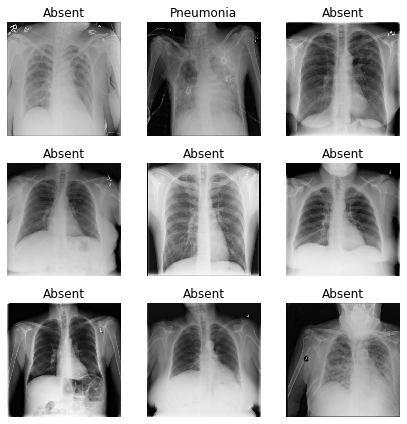

In [3]:
binary_data.show_batch(rows=3, figsize=(6,6))

In [4]:
print(binary_data.classes)

['Absent', 'Pneumonia']


In [5]:
binary_data

ImageDataBunch;

Train: LabelList (21348 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Absent,Absent,Absent,Absent,Pneumonia
Path: data/new_xray/train_png;

Valid: LabelList (5336 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Absent,Absent,Absent,Absent,Absent
Path: data/new_xray/train_png;

Test: None

In [7]:
binary['Target'].value_counts()

Absent       20672
Pneumonia     6012
Name: Target, dtype: int64

## ResNet34

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-07
Min loss divided by 10: 6.31E-03


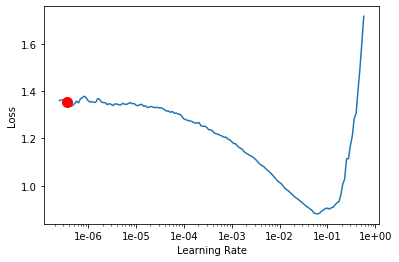

In [56]:
from fastai.vision import cnn_learner
from fastai.vision import models
from fastai.vision import error_rate

learn = cnn_learner(binary_data, models.resnet34, metrics=error_rate)
learn.lr_find(num_it=200)
learn.recorder.plot(suggestion=True)

In [58]:
# learn.model
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.803536,0.490893,0.212144,03:39
1,0.490822,0.406513,0.185345,03:38
2,0.396389,0.391066,0.180847,03:37
3,0.363713,0.388792,0.175787,03:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-05
Min loss divided by 10: 1.58E-05


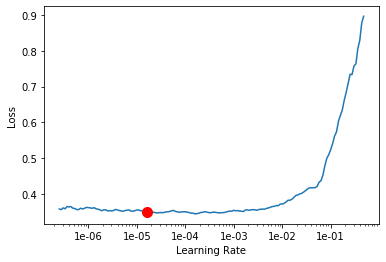

In [60]:
learn.lr_find(num_it=200)
learn.recorder.plot(suggestion=True)

In [61]:
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.372822,0.398953,0.184783,03:38
1,0.344055,0.382957,0.167354,03:37


In [62]:
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.357081,0.387813,0.171664,03:39
1,0.322051,0.383396,0.169228,03:38


In [49]:
save_path = '/home/jupyter/tutorials/fastai/course-v3/nbs/fastai/models/resnet34_frozen_271019'
learn.save(save_path)

Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.91E-05


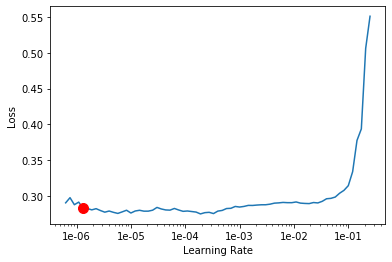

In [51]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [52]:
learn.fit_one_cycle(4, max_lr=1.91E-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.284504,0.355858,0.157234,03:37
1,0.275942,0.357476,0.157796,03:36
2,0.272287,0.357409,0.157609,03:37
3,0.274230,0.357684,0.157984,03:37


### Results

In [16]:
from fastai.vision import ClassificationInterpretation
from fastai.vision import cnn_learner
from fastai.vision import models
from fastai.vision import error_rate

learn = cnn_learner(binary_data, models.resnet34, metrics=error_rate)
learn.load(save_path)

interpretation = ClassificationInterpretation.from_learner(learn)
losses, indexes = interpretation.top_losses() # Gets the top losses (where we were most sure but wrong)

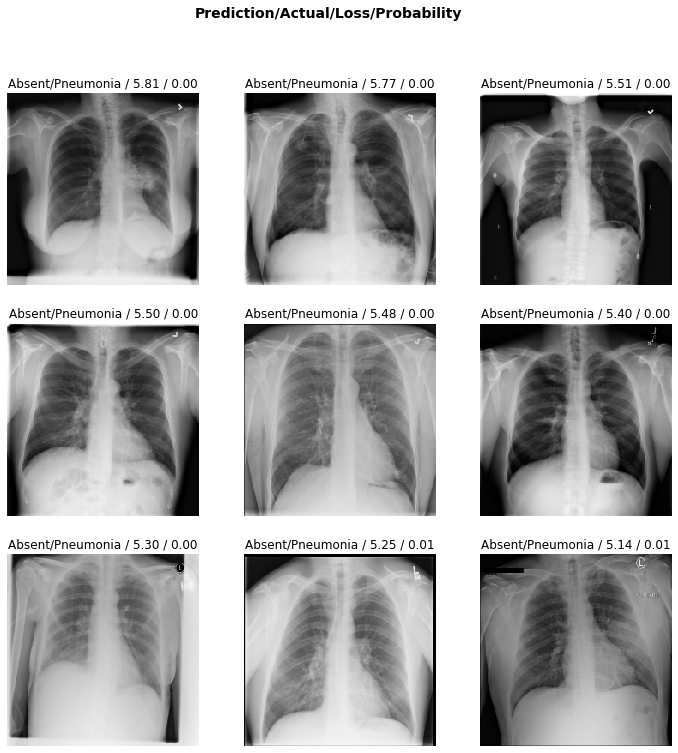

In [17]:
interpretation.plot_top_losses(9, figsize=(12, 12)) # Probability that it was the correct label.

(1.5, -0.5)

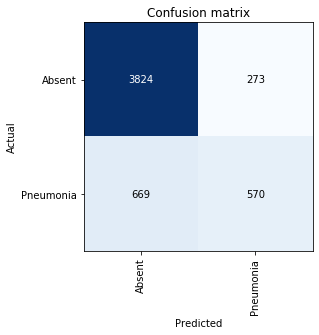

In [18]:
cm_fig = interpretation.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interpretation.data.c - .5, - .5)

In [14]:
interpretation.most_confused()

[('NORMAL', 'PNEUMONIA', 110), ('PNEUMONIA', 'NORMAL', 7)]

## Unfreeze

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


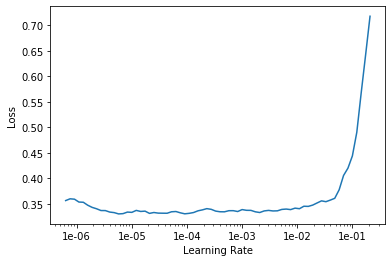

In [20]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.090590,0.645466,0.185897,01:04
1,0.084386,0.663157,0.192308,01:04


In [ ]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time


## ResNet 50